# Solving the 1D Burgers' Equation Using Physics-Informed Neural Networks (PINNs)

## Governing Equation

We consider the 1D Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1]
$$

with viscosity:

$$
\nu = \frac{0.01}{\pi}
$$


In [14]:
!pip install optax

In [15]:
!pip install jaxopt dm-haiku optax

# Imports

In [16]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from jax.flatten_util import ravel_pytree
from jaxopt import LBFGS
import logging
import pandas as pd
from jax import grad, jit, vmap, value_and_grad
from functools import partial
import haiku as hk
from scipy.stats import qmc
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# Set up

In [17]:
lr_initial = 0.001
epochs = 10000

# Sampling parameters
N_interior = 5000
N_boundary = 1000
N_test = 2500

# Domain limits
x_min, x_max = -1.0, 1.0
t_min, t_max = 0, 1.0

# Boundary Conditions

$$
    u(x, 0) = -\sin(\pi x), \quad x\in[-1,1]
$$

$$
    u(-1, t) = 0, \quad u(1, t) = 0 \quad \text{for all } t \in [0, 1]
$$


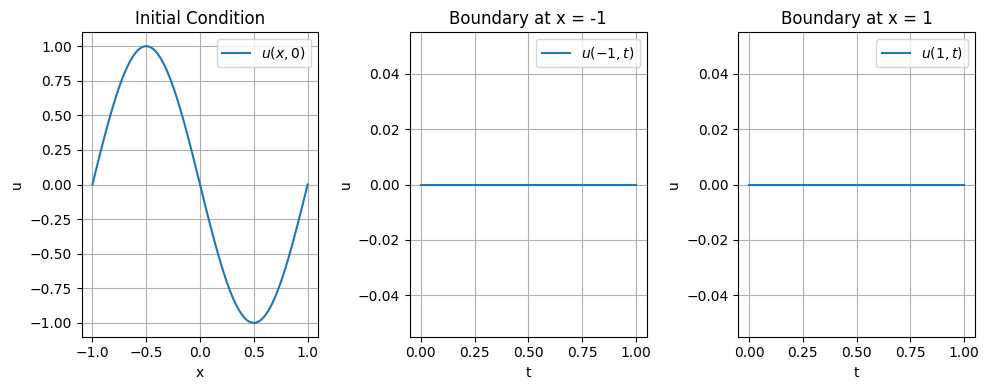

In [18]:
# Define Initial Condition: u(x, 0) = -sin(pi * x)
def Initial_condition(x_ic):
    x = x_ic[:, 0:1]
    return -jnp.sin(jnp.pi * x)

# Boundary condition at x = -1 for all t
def boundary_condition1(x_bc1):
    return jnp.zeros((x_bc1.shape[0], 1))

# Boundary condition at x = 1 for all t
def boundary_condition2(x_bc2):
    return jnp.zeros((x_bc2.shape[0], 1))

# Generate x for initial condition
x = np.linspace(-1, 1, 100).reshape(-1, 1)
x_ic = np.hstack([x, np.zeros_like(x)])  # (x, t=0)
u_ic = Initial_condition(jnp.array(x_ic))

# Generate t for boundary conditions
t = np.linspace(t_min, t_max, 100).reshape(-1, 1)
x_left = -np.ones_like(t)
x_right = np.ones_like(t)
x_bc1 = np.hstack([x_left, t])  # (x=-1, t)
x_bc2 = np.hstack([x_right, t])  # (x=1, t)
u_bc1 = boundary_condition1(jnp.array(x_bc1))
u_bc2 = boundary_condition2(jnp.array(x_bc2))

# Plot using GridSpec
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 3, figure=fig)

# Plot initial condition
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(x, u_ic, label=r'$u(x, 0)$')
ax0.set_title("Initial Condition")
ax0.set_xlabel("x")
ax0.set_ylabel("u")
ax0.grid(True)
ax0.legend()

# Plot boundary condition at x = -1
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(t, u_bc1, label=r'$u(-1, t)$')
ax1.set_title("Boundary at x = -1")
ax1.set_xlabel("t")
ax1.set_ylabel("u")
ax1.grid(True)
ax1.legend()

# Plot boundary condition at x = 1
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(t, u_bc2, label=r'$u(1, t)$')
ax2.set_title("Boundary at x = 1")
ax2.set_xlabel("t")
ax2.set_ylabel("u")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


# Neural Network (PINN) Setup

Input: $ (x, t) \in \mathbb{R}^2 $ \\
Architecture: 8 hidden layers with 20 neurons each \\
Activation Function: tanh \\
Output: Scalar prediction $ u(x, t) $ \\
Initialization: Latin Hypercube Sampling (LHS) with Glorot-like variance scaling


In [19]:
# --- Custom LHS initializer with Glorot-like scaling ---
class LHSInitializer(hk.initializers.Initializer):
    def __init__(self, scale=1.0):
        self.scale = scale

    def __call__(self, shape, dtype):
        if len(shape) != 2:
            raise ValueError("LHSInitializer only supports 2D shapes (for weights).")

        fan_in, fan_out = shape
        total_dim = fan_in * fan_out

        # Generate LHS samples in [0, 1]
        sampler = qmc.LatinHypercube(d=total_dim)
        lhs_sample = sampler.random(n=1).reshape((fan_in, fan_out))

        # Scale to [-1, 1]
        lhs_scaled = 2.0 * lhs_sample - 1.0

        # Glorot-like scaling
        glorot_std = self.scale * jnp.sqrt(2.0 / (fan_in + fan_out))
        lhs_scaled = lhs_scaled * glorot_std

        return jnp.array(lhs_scaled, dtype=dtype)

def MLP():
    layers = [32, 64, 128, 64]
    lhs_init = LHSInitializer(scale=1.0)

    hidden = hk.nets.MLP(
        layers,
        activation=jax.nn.tanh,
        w_init=lhs_init,
        b_init=hk.initializers.Constant(0.0)
    )

    output_layer = hk.Linear(1, w_init=lhs_init, b_init=hk.initializers.Constant(0.0))
    return hk.Sequential([hidden, output_layer])

def model_fn(x_t):
    net = MLP()
    return net(x_t)

model = hk.transform(model_fn)

# @jax.jit
def model_output(full_params, x):
    u = model.apply(full_params, None, x)
    return u

# Input setup

In [20]:
key = jax.random.PRNGKey(0)
key, subkey1, subkey2 = jax.random.split(key, 3)

x_init = jax.random.uniform(subkey1, (N_interior, 2), minval=jnp.array([x_min, t_min]), maxval=jnp.array([x_max, t_max]))
x_ic_x = jax.random.uniform(subkey2, (N_boundary, 1), minval=-1.0, maxval=1.0)
x_ic_t = jnp.zeros_like(x_ic_x)
x_ic = jnp.hstack((x_ic_x, x_ic_t))

x_bc1_t = jax.random.uniform(subkey2, (N_boundary, 1), minval=0.0, maxval=1.0)
x_bc1_x = -jnp.ones_like(x_bc1_t)
x_bc1 = jnp.hstack((x_bc1_x, x_bc1_t))

x_bc2_t = jax.random.uniform(subkey2, (N_boundary, 1), minval=0.0, maxval=1.0)
x_bc2_x = jnp.ones_like(x_bc2_t)
x_bc2 = jnp.hstack((x_bc2_x, x_bc2_t))

params = model.init(key, x_init)

# Loss Functions

### PDE Loss (Residual):
$$
    MSE_{residual} = \text{mean}\left[\left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} \right)^2\right]
$$

### Initial Condition Loss:
$$
    \text{MSE}_{\text{IC}} = \text{mean}( u(x, 0) + sin(πx))^2]
$$

### Boundary Condition Loss:
$$
    \text{MSE}_{\text{BC}} = \text{mean}\left[u(-1, t)^2\right] + \text{mean}\left[u(1, t)^2\right]
$$

## Total Loss:

$$
\mathcal{L}_{\text{total}} = \text{MSE}_{\text{residual}} + \text{MSE}_{\text{IC}} + \text{MSE}_{\text{BC}}
$$

In [21]:
# PDE loss (Burgers' equation)
def compute_pde_loss(params, x_init, model_apply):
    def u_fn(x):
        return model_apply(params, None, x).reshape(())  # safe scalar

    # First-order derivatives ∂u/∂x, ∂u/∂t
    du_fn = grad(u_fn)
    du_vals = vmap(du_fn)(x_init)
    u_x = du_vals[:, 0:1]
    u_t = du_vals[:, 1:2]

    # Second-order derivative ∂²u/∂x²
    d2u_dx_fn = grad(lambda x: grad(u_fn)(x)[0])  # [0] means ∂/∂x
    u_xx = vmap(d2u_dx_fn)(x_init)[:, 0:1]

    # u values
    u_vals = vmap(u_fn)(x_init).reshape(-1, 1)

    # PDE residual: ∂u/∂t + u ∂u/∂x − ν ∂²u/∂x²
    nu = 0.01 / jnp.pi
    pde_res = u_t + u_vals * u_x - nu * u_xx
    pde_loss = jnp.mean(pde_res ** 2)

    return pde_loss

# Initial condition loss
def ic_loss(params, x_ic, model_apply):
    u_ic = model_apply(params, None, x_ic).reshape(-1)
    exact = Initial_condition(x_ic).reshape(-1)
    return jnp.mean((u_ic - exact) ** 2)

# Boundary condition 1 loss
def bc1_loss(params, x_bc1, model_apply):
    u_bc1 = model_apply(params, None, x_bc1).reshape(-1)
    exact = boundary_condition1(x_bc1).reshape(-1)
    return jnp.mean((u_bc1 - exact) ** 2)

# Boundary condition 2 loss
def bc2_loss(params, x_bc2, model_apply):
    u_bc2 = model_apply(params, None, x_bc2).reshape(-1)
    exact = boundary_condition2(x_bc2).reshape(-1)
    return jnp.mean((u_bc2 - exact) ** 2)

# Total loss function
def total_loss(params, x_init, x_ic, x_bc1, x_bc2, model_apply):
    pde = compute_pde_loss(params, x_init, model_apply)
    ic = ic_loss(params, x_ic, model_apply)
    bc1 = bc1_loss(params, x_bc1, model_apply)
    bc2 = bc2_loss(params, x_bc2, model_apply)

    # Safe debug print using jax.debug
    # jax.debug.print(
    #     "[Loss Breakdown] PDE: {p:.3e} | IC: {i:.3e} | BC1: {b1:.3e} | BC2: {b2:.3e}",
    #     p=pde, i=ic, b1=bc1, b2=bc2
    # )

    return pde + 10 * (ic + bc1 + bc2)

# Training Procedure

  Optimizer 1: Adam optimizer, 5000 epochs with learning rate $ \text{lr} = 10^{-3} $ \\
Optimizer 2 (optional): L-BFGS optimizer for fine-tuning \\
The optimizers minimize the total loss $ \mathcal{L}_{\text{total}} $



In [22]:
from jaxopt import LBFGS
from jax.flatten_util import ravel_pytree

def lbfgs_train_only(params, model, x_init, x_ic, x_bc1, x_bc2,
                     maxiter=5000, tol=1e-8):
    """
    Train using L-BFGS only, with jaxopt.
    """
    print("Starting L-BFGS training...")

    def loss_fn(p):
        return total_loss(p, x_init, x_ic, x_bc1, x_bc2, model.apply)

    flat_params, unravel_fn = ravel_pytree(params)

    def flat_loss_fn(flattened):
        return loss_fn(unravel_fn(flattened))

    solver = LBFGS(fun=flat_loss_fn, maxiter=maxiter, tol=tol)
    result = solver.run(flat_params)

    final_params = unravel_fn(result.params)

    print(f"L-BFGS done. Final loss: {float(result.state.value):.5e}")
    return final_params

# Usage:
params = lbfgs_train_only(params, model, x_init, x_ic, x_bc1, x_bc2, maxiter=5000, tol=1e-8)


Starting L-BFGS training...
L-BFGS done. Final loss: 1.94324e-02


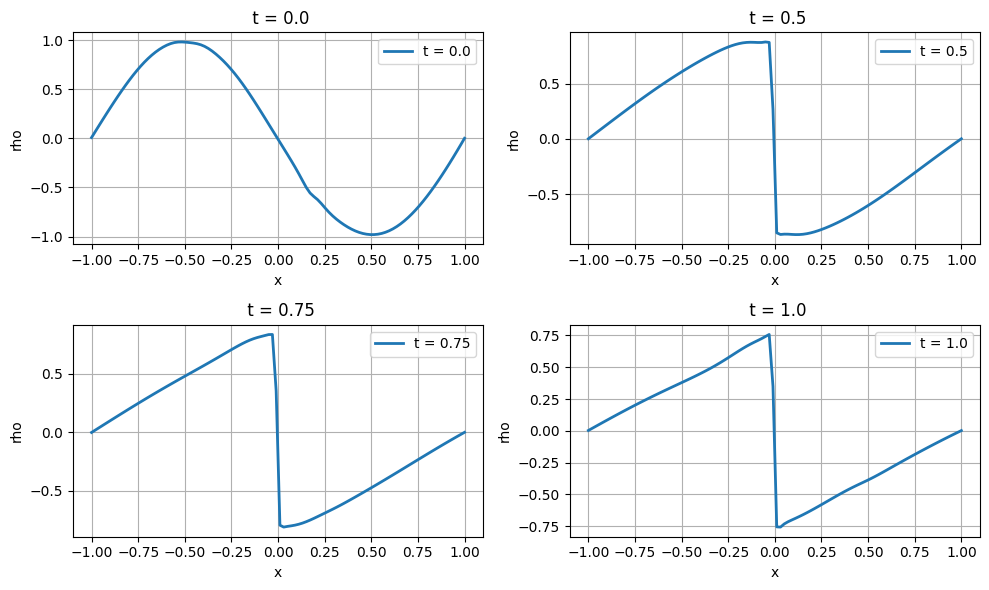

In [23]:
# Define spatial domain
x_vals = jnp.linspace(-1.0, 1.0, 100)

# Define time slices
t_slices = [0.0, 0.5, 0.75, 1.0]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()  # Flatten to iterate easily

# Loop over time slices and plot
for i, t_val in enumerate(t_slices):
    # Create input [x, t]
    xt_input = jnp.stack([x_vals, jnp.full_like(x_vals, t_val)], axis=1)

    # Predict using the model
    u_pred = model_output(params, xt_input)

    # Convert to NumPy
    u_pred = jax.device_get(u_pred).squeeze()

    # Plot
    ax = axes[i]
    ax.plot(x_vals, u_pred, label=f't = {t_val}', linewidth=2)
    ax.set_title(f' t = {t_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('rho')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=e9461a263604bc341b0ee551a41f33e794db8f6004535d1cd731f2c4f2d3c13e
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


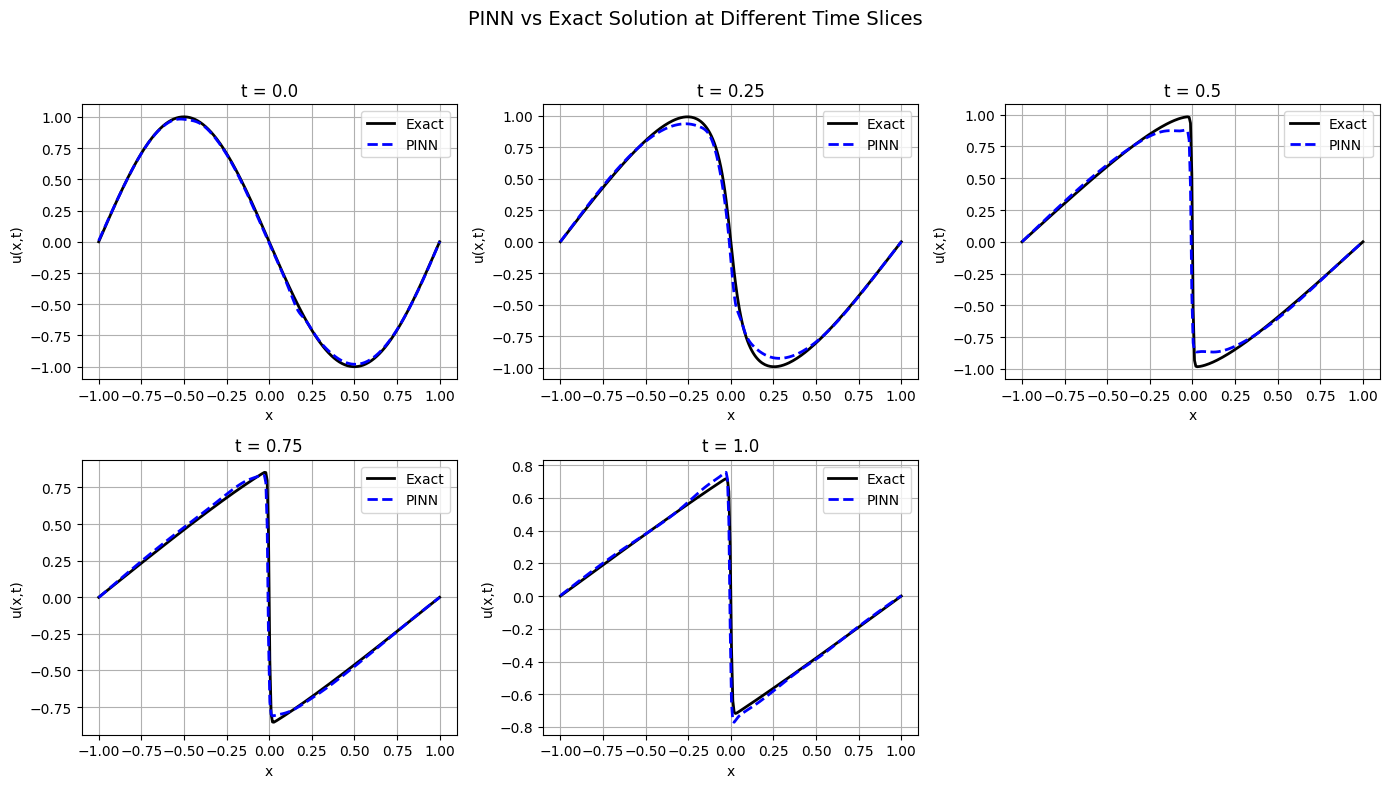

In [25]:
from scipy.io import loadmat

# Load exact Burgers data
mat = loadmat('/content/burgers_shock.mat')
x = mat['x'].flatten()
t = mat['t'].flatten()
Exact = np.real(mat['usol'])  # shape: (len(x), len(t))

# Define time slices to compare
time_slices = [0.0, 0.25, 0.5, 0.75, 1.0]

# Predict using your model at each time slice
x_vals = jnp.array(x)
U_pred = []

for t_val in time_slices:
    xt_input = jnp.stack([x_vals, jnp.full_like(x_vals, t_val)], axis=1)
    u_pred_t = model_output(params, xt_input)
    u_pred_t = jax.device_get(u_pred_t).squeeze()  # shape: (len(x),)
    U_pred.append(u_pred_t)

U_pred = np.array(U_pred)  # shape: (len(time_slices), len(x))

# --- Plotting both in same figure ---
plt.figure(figsize=(14, 8))

for i, t_val in enumerate(time_slices):
    t_index = np.argmin(np.abs(t - t_val))

    u_exact_t = Exact[:, t_index]
    u_pinn_t = U_pred[i]

    plt.subplot(2, 3, i + 1)
    plt.plot(x, u_exact_t, 'k-', linewidth=2, label='Exact')
    plt.plot(x, u_pinn_t, 'b--', linewidth=2, label='PINN')
    plt.title(f't = {t_val}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.grid(True)
    plt.legend()

plt.suptitle('PINN vs Exact Solution at Different Time Slices', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Spatial Gradient $\frac{∂u}{∂x}$
### at  $t=[0.0, 0.5,0.75, 1.0]$

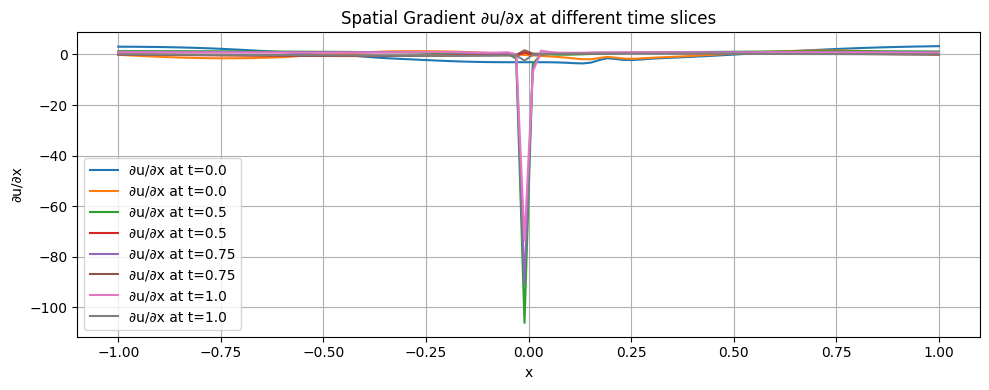

In [26]:
# Define a batched function for ∂u/∂x with input xt = (x, t)
 # @jax.jit
def grad_u_wrt_x(params, xt_batch):
    def u_fn(x_t):
        return model_output(params, x_t).squeeze()
    grad_fn = jax.vmap(jax.grad(u_fn))  # gradient wrt x_t[0]
    return grad_fn(xt_batch)

# Spatial domain
x_vals = jnp.linspace(-1.0, 1.0, 100)

# Time slices
t_slices = [0.0, 0.5, 0.75, 1.0]

plt.figure(figsize=(10, 4))

for t in t_slices:
    xt = jnp.stack([x_vals, jnp.full_like(x_vals, t)], axis=1)  # (100, 2)
    du_dx = grad_u_wrt_x(params, xt)
    plt.plot(x_vals, du_dx, label=f"∂u/∂x at t={t}")

plt.title("Spatial Gradient ∂u/∂x at different time slices")
plt.xlabel("x")
plt.ylabel("∂u/∂x")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exploding Spatial Gradient Locations

Found 90 points with |∂u/∂x| > 50.0:


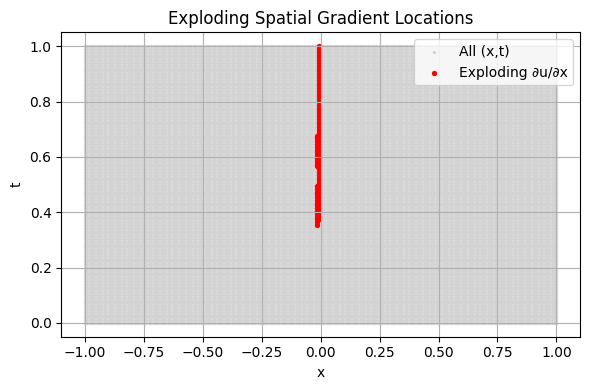

In [27]:
# Define dense (x, t) grid
x_vals = jnp.linspace(-1.0, 1.0, 200)
t_vals = jnp.linspace(0.0, 1.0, 100)
X, T = jnp.meshgrid(x_vals, t_vals)
xt_grid = jnp.stack([X.flatten(), T.flatten()], axis=-1)  # shape (200*100, 2)

# Define function to compute ∂u/∂x
def du_dx_fn(params, xt):
    def u_fn(x):
        xt_new = jnp.array([x, xt[1]])  # x varies, t fixed
        return model_output(params, xt_new[None, :]).squeeze()
    return jax.grad(u_fn)(xt[0])

# Vectorized computation of ∂u/∂x for all (x, t)
du_dx_all = jax.vmap(lambda xt: du_dx_fn(params, xt))(xt_grid)

# Convert to NumPy
xt_np = np.array(xt_grid)
du_dx_np = np.array(du_dx_all)

# Threshold for explosion
threshold = 50.0

# Mask and collect exploding points
exploding_mask = np.abs(du_dx_np) > threshold
exploding_points = xt_np[exploding_mask]

# Print or save exploding points
print(f"Found {len(exploding_points)} points with |∂u/∂x| > {threshold}:")
# for x, t in exploding_points:
    # print(f"x = {x:.3f}, t = {t:.3f}")

# Optional: plot exploding points on domain
plt.figure(figsize=(6, 4))
plt.scatter(xt_np[:, 0], xt_np[:, 1], c='lightgray', s=2, label="All (x,t)")
plt.scatter(exploding_points[:, 0], exploding_points[:, 1], c='red', s=8, label="Exploding ∂u/∂x")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Exploding Spatial Gradient Locations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
# Convert exploding points to jax array
exploding_points_jnp = jnp.array(exploding_points)

# Augment original x_init with exploding points
x_init_augmented = jnp.concatenate([x_init, exploding_points_jnp], axis=0)


In [29]:
params = model.init(jax.random.PRNGKey(0), x_init_augmented)

# Train again with the augmented initial data (x_init)
params = lbfgs_train_only(params, model, x_init_augmented, x_ic, x_bc1, x_bc2, maxiter=5000, tol=1e-8)


Starting L-BFGS training...
L-BFGS done. Final loss: 5.47227e-02


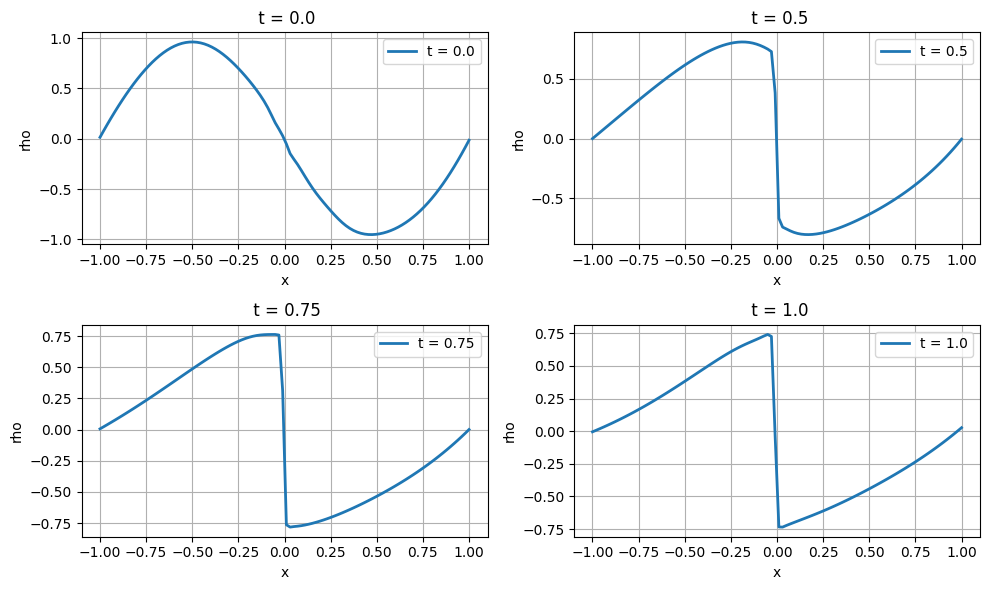

In [30]:
# Define spatial domain
x_vals = jnp.linspace(-1.0, 1.0, 100)

# Define time slices
t_slices = [0.0, 0.5, 0.75, 1.0]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()  # Flatten to iterate easily

# Loop over time slices and plot
for i, t_val in enumerate(t_slices):
    # Create input [x, t]
    xt_input = jnp.stack([x_vals, jnp.full_like(x_vals, t_val)], axis=1)

    # Predict using the model
    u_pred = model_output(params, xt_input)

    # Convert to NumPy
    u_pred = jax.device_get(u_pred).squeeze()

    # Plot
    ax = axes[i]
    ax.plot(x_vals, u_pred, label=f't = {t_val}', linewidth=2)
    ax.set_title(f' t = {t_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('rho')
    ax.grid(True)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Exact Solution of the 1D Burgers' Equation

We consider the 1D viscous Burgers' equation:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1],
$$
with initial and boundary conditions:
$$
u(x, 0) = -\sin(\pi x), \quad u(-1, t) = u(1, t) = 0,
$$
and viscosity:
$$
\nu = \frac{0.01}{\pi}.
$$

## Cole–Hopf Transformation

Let us define a transformation:
$$
u(x,t) = -2 \nu \frac{\partial}{\partial x} \ln \phi(x,t),
$$
where $ \phi(x,t) $ satisfies the heat equation:
$$
\frac{\partial \phi}{\partial t} = \nu \frac{\partial^2 \phi}{\partial x^2}.
$$

## Integral Form of Exact Solution

The exact solution can be written as:
$$
u(x,t) = \frac{
    \displaystyle \int_{-1}^{1} \sin(\pi \xi) \exp\left(-\frac{(x - \xi)^2}{4\nu t}\right) d\xi
}{
    \displaystyle \int_{-1}^{1} \exp\left(-\frac{(x - \xi)^2}{4\nu t}\right) d\xi
}.
$$

This expression must be evaluated numerically due to the integral form.